In [2]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import twitter_samples 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
import time
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## **Importing and Reviewing Data**

In [5]:
dataset = pd.read_json('/content/drive/My Drive/Machine Learning/Sentiment_Analysis/Electronics_5.json', lines = True)

Let's first check the data content.

In [6]:
dataset.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


Checking for null values:

In [7]:
dataset.isnull().sum()

reviewerID            0
asin                  0
reviewerName      24730
helpful               0
reviewText            0
overall               0
summary               0
unixReviewTime        0
reviewTime            0
dtype: int64

In this datset, we will use the 'reviewText' and 'overal' columns, which are the reviews and the corresponding rating provided by the reviewer.
The overal review rating is an integer from 1 to 5. In this project, we want to train a Naive Bayes model that can predict the review as being positive or negative. Hence, we consider reviews with rate of 4 and 5 as positive, and rates of 1 and 2 as negative reviews. We will ignore the rates of 3 (the neutral ratings).

Let's check the frequency of each review rating:

In [8]:
dataset['overall'].value_counts()

5    1009026
4     347041
3     142257
1     108725
2      82139
Name: overall, dtype: int64

Using the criteria mentioned above, let's categorize the reviews as positive and negative:

In [9]:
positive_boolean = dataset['overall'] >= 4
negative_boolean = dataset['overall'] <= 2

In [10]:
positive_reviews = dataset['reviewText'].loc[positive_boolean]
pos_reviews = positive_reviews.to_list()

In [11]:
negative_reviews = dataset['reviewText'].loc[negative_boolean]
neg_reviews = negative_reviews.to_list()

In [12]:
n_pos = len(positive_reviews)
n_neg = len(negative_reviews)
print(f'We have {n_pos} positive reviews and {n_neg} negative reviews')

We have 1356067 positive reviews and 190864 negative reviews


Let's take a look at some example random reviews:

In [13]:
print('Example of a positive review:\n', pos_reviews[1010], '\n')
print(pos_reviews[100000], '\n')
print('\nExample of a negative review:\n', neg_reviews[2104], '\n')
print(neg_reviews[12000])

Example of a positive review:
 I wanted a radio to listen to NPR for a few minutes in the morning without putting on the stereo.  I did not want a CD or tape player.  This is a good little basic radio and I am pleased with it. 

This switch works as described, nothing more nothing less.  The 4sSignal passing through it is clean and no difference is observed when it is installed.  It operates exactly as expected. 


Example of a negative review:
 Cons: this camera is heavy and bulky.  For the price, it is only around 2 mega pixels which isnt good.  I had this camera for a while then the zoom wouldnt come all the way out and it says "system error" every time  i turn it on so i cannot use it anymore.Pros:  the pictures turn out decent.  It is a solid camera but do not drop it on the lens contraption because you will have the same problem of it not turning on and its garabe now. 

I tried to attach this cable to link my HDTV and computer but apparently I am missing something...I still have

We will use 60,000 positive and 60,000 negative reviews. Based on the performance analysis, we will decide if more data is required or not.

In [14]:
pos_reviews = pos_reviews[:60000]
neg_reviews = neg_reviews[:60000]

Define training and test data with 80/20 ratio.

In [15]:
X_train_pos = pos_reviews[:48000]  # 80% of data
X_train_neg = neg_reviews[:48000]
X_test_pos = pos_reviews[48000:]
X_test_neg = neg_reviews[48000:]
X_train = X_train_pos + X_train_neg
X_test = X_test_pos + X_test_neg
y_train = np.append(np.ones((48000,1)), np.zeros((48000,1)), axis = 0) 
y_test = np.append(np.ones((12000, 1)), np.zeros((12000,1)), axis = 0)

Define a function to preprocess the review texts. This included removing punctuations, digits, stop words,... and tokenization.
We are also using word stemmer.

In [21]:
def preprocess_text(review):
  stopwords_english = stopwords.words('english')
  review = re.sub(r'\d','', review)
  review = re.sub(r'"','', review)
  review = re.sub(r'\.\.\.','', review)
  review = re.sub(r'[A-Z]{2,}', '', review)
  review = re.sub(r"n't", "not", review)
  review = re.sub(r"\'s", "", review)
  review = re.sub(r"\'ve", "have", review)
  review = re.sub(r"\'re", "are", review)
  review = re.sub(r"\'d", "would", review)
  review = re.sub(r"\'ll", "will", review)
  review = re.sub(r"i'm", "I am", review)
  stemmer = PorterStemmer()
  review_lower = review.lower()
  review_tokens = word_tokenize(review_lower)
  processed_text =[]
  for word in review_tokens:
    if (word not in stopwords.words('english') and word not in string.punctuation):
      stem_word = stemmer.stem(word)
      processed_text.append(stem_word)
  return processed_text

Define a function to provide us with the frequency of each word in the positive and negative categories in a frequency dictionary.

In [22]:
def freq_dict(reviews, y):
  y_list = np.squeeze(y).tolist()
  freq = {}
  for review,y in zip(reviews, y_list):
    review_p = preprocess_text(review)
    for word in review_p:
      key = (word, y)
      if key in freq:
        freq[key] += 1
      else:
        freq[key] = 1
  return freq

Use the above function to create our frequency dictionary.

In [23]:
freqs = freq_dict(X_train,y_train)

Next, we calculate the number of unique words, V, logprior and loglikelihood. We are using equal number of positive and negative reviews. Hence, logprior is equal to zero.

In [24]:
words = set([key[0] for key in freqs.keys()])
V = len(words)
N_pos = 0
N_neg = 0
for k, v in freqs.items():
  if k[1]==0:
    N_neg += v
  else:
    N_pos += v

In [25]:
log_likelihood_dict = {}
for word in words:
  log_likelihood_dict[word] = np.log((freqs.get((word, 1), 0) + 1)/(N_pos + V)) - np.log((freqs.get((word, 0),0) + 1)/(N_neg + V)) 

Now, let's define a prediction function.

In [26]:
def predict(reviews, log_likelihood_dict):
  yhat=np.zeros((len(reviews),1))
  for i in range(len(reviews)):
    p = 0
    review = preprocess_text(reviews[i])
    for word in review:
      p += log_likelihood_dict.get(word, 0)
    if p>0:
      yhat[i] = 1
    else:
      yhat[i] = 0
  return yhat

In [27]:
y_test_pred = predict(X_test, log_likelihood_dict)
y_train_pred = predict(X_train, log_likelihood_dict)

## **Model Performance Analysis**

Calculate the accuracy and F1-score for training and test data:

In [28]:
print('For training data:')
print("Accuracy: ",round(metrics.accuracy_score(y_train,y_train_pred),3))
print("F1-score: ",round(metrics.f1_score(y_train, y_train_pred),3))

For training data:
Accuracy:  0.862
F1-score:  0.86


In [29]:
print('For test data: ')
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_test_pred),3))
print("F1-score: ",round(metrics.f1_score(y_test, y_test_pred),3))

For test data: 
Accuracy:  0.85
F1-score:  0.846


The accuracy seems better than what we achieved using logistic regression (0.7 for test data). Also, the test accuracy is quite close to the training accuracy. Hence, we don't have a big variance, which means adding more data will not improve the model performance.

Create the confusion matrix for visual analysis of the performance:

Text(15.0, 0.5, 'Actual Sentiment')

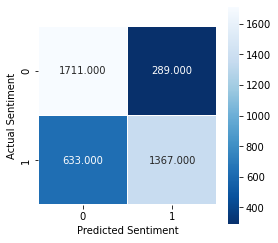

In [28]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')

Let's see which words are the most frequent ones in this data.

In [30]:
sorted_freq = {k:v for k,v in sorted(freqs.items(), key = lambda item:item[1], reverse = True)}

In [31]:
def top_words_plt(sorted_freq): # n refering to 0 or 1 for negative or positive
  category = ['negative', 'positive']
  c = ['red', 'green']
  fig, ax = plt.subplots(1,2, figsize = (20,5))
  for n in range(0,2):
    most_common = {}
    i = 1
    for key, freq in sorted_freq.items():
      if key[1] == n:
        most_common[key[0]] = freq
        i += 1
        if i > 30:
          break
    ax[n].bar(most_common.keys(), most_common.values(), color = c[n])
    ax[n].set_title('Most common words for '+ category[n]+ ' category')
    ax[n].set_xlabel('words')
    ax[n].set_ylabel('frequency')
    xlabels = most_common.keys()
    ax[n].set_xticklabels(xlabels, rotation = 60)

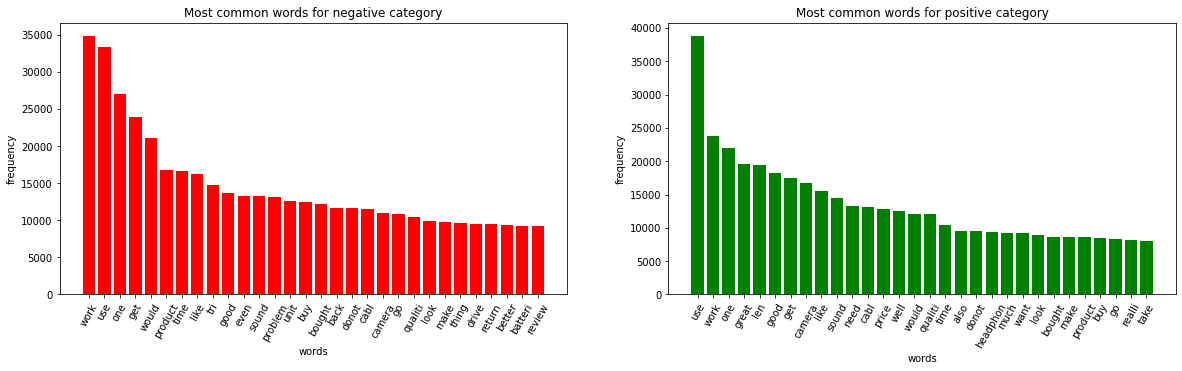

In [32]:
top_words_plt(sorted_freq)

In [33]:
pos_reviews_train = "".join(review for review in X_train_pos)
neg_reviews_train = "".join(review for review in X_train_neg)

wordcloud_pos = WordCloud(background_color='white').generate(pos_reviews_train)
wordcloud_neg = WordCloud(background_color='white').generate(neg_reviews_train)

(-0.5, 399.5, 199.5, -0.5)

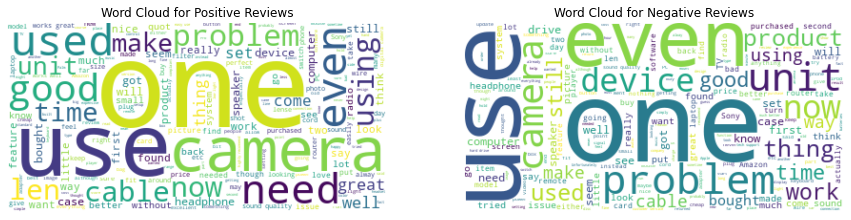

In [34]:
fig, ax = plt.subplots(1,2, figsize = (15,8))
ax[0].imshow(wordcloud_pos, interpolation = 'bilinear')
ax[0].set_title('Word Cloud for Positive Reviews')
ax[1].imshow(wordcloud_neg, interpolation = 'bilinear')
ax[1].set_title('Word Cloud for Negative Reviews')
ax[0].axis('off')
ax[1].axis('off')

## **Conclusion**

The Naive Bayes model provided a better prediction performance than logisit regression on this dataset. As shown with the bar chart of frequencies as well as in the word cloud plots, we wee a high frequency use of neutral words such as 'one', 'use', 'device', ...in both positive and negative sentiment categories. There is very small difference in the frequency of these neutral words, which may be contributing to part of the error. At the same time, we see that the positive and negative sentiment reviews are indeed correlated with the use of positive and negative sentiment words such as "great" and "good".
To get a better prediction performance, the model needs to capture the context of words in each review. This cannot be done with Naive Bayes model, and more advanced methods will be investigated. 